## Eastern Demand Gathering Demo, V6
Authors: Bainan, Dan M.

Last updated: 12/03/19

In [1]:
import pandas as pd
import numpy as np
import requests as r
import json
import pickle
import matplotlib as plt
from collections import Counter, defaultdict
from prereise.gather.demanddata.eia import download_map_demand, find_fix_outliers, get_eia_data, fill_missing_demand
from prereise.gather.demanddata.eia import transform_demand_to_region, map_grid_buses_to_county, transform_ba_to_loadzone
from powersimdata.input.grid import Grid
import json

BAs are associated with abbreviations. Demand data from EIA is imported using an API Key.
Note that data for some BAs will not be found (i.e., YAD) and this will be reported by the download_map_demand.get_BA_demand function.

In [2]:
eastern_ba = ['SWPP','MISO','AECI','SPA','EEI','LGEE','OVEC','PJM','NYIS','ISNE','TVA','CPLW','DUK','YAD','CPLE','AEC','SOCO','SEPA','SC','TAL','SCEG','GVL','JEA','SEC','FPC','NSB','TEC','FMPP','FPL','HST']

In [3]:
start = pd.to_datetime('2016-01-01 00:00:00')
end = pd.to_datetime('2016-12-31 23:00:00')

eastern_demand = download_map_demand.get_BA_demand(eastern_ba, start, end, 'd826fe7862968708eb6a3c2639d6da1b')
eastern_demand_2016 = eastern_demand.loc[start:end]
eastern_demand_2016

EEI not found
YAD not found
SEPA not found


,SWPP,MISO,AECI,SPA,LGEE,OVEC,PJM,NYIS,ISNE,TVA,...,SCEG,GVL,JEA,SEC,FPC,NSB,TEC,FMPP,FPL,HST
2016-01-01 00:00:00+00:00,30875.0,78481.0,2917.0,68.0,4280.0,NaN,95072.0,19726.0,16063.0,18742.0,...,2637.0,270.0,NaN,175.0,7389.0,65.0,2969.0,2507.0,18036.0,84.0
2016-01-01 01:00:00+00:00,31457.0,77902.0,2946.0,83.0,4245.0,NaN,92298.0,19008.0,15273.0,18555.0,...,2558.0,258.0,NaN,164.0,6931.0,61.0,2778.0,2386.0,16990.0,79.0
2016-01-01 02:00:00+00:00,30969.0,75821.0,2910.0,58.0,4078.0,NaN,89416.0,18340.0,14568.0,18180.0,...,2487.0,244.0,NaN,152.0,0.0,53.0,2575.0,2226.0,15650.0,73.0
2016-01-01 03:00:00+00:00,30397.0,73863.0,2878.0,80.0,3935.0,NaN,86496.0,17557.0,13850.0,17744.0,...,2374.0,229.0,NaN,140.0,5830.0,51.0,2397.0,2049.0,14406.0,66.0
2016-01-01 04:00:00+00:00,29818.0,71919.0,2829.0,69.0,3793.0,NaN,83405.0,16772.0,13108.0,17306.0,...,2256.0,213.0,NaN,128.0,5405.0,48.0,2223.0,1908.0,13389.0,60.0
2016-01-01 05:00:00+00:00,29085.0,69589.0,2779.0,63.0,3669.0,NaN,80685.0,16055.0,12737.0,16731.0,...,2127.0,197.0,NaN,117.0,4969.0,43.0,2091.0,1760.0,12411.0,56.0
2016-01-01 06:00:00+00:00,28343.0,67929.0,2707.0,68.0,3650.0,80.0,78661.0,15250.0,12503.0,16298.0,...,2014.0,184.0,1181.0,107.0,4617.0,40.0,1960.0,1636.0,12043.0,53.0
2016-01-01 07:00:00+00:00,27803.0,66212.0,2681.0,70.0,3566.0,80.0,77817.0,14583.0,12241.0,15975.0,...,1941.0,176.0,1128.0,100.0,4328.0,37.0,1859.0,1566.0,11393.0,52.0
2016-01-01 08:00:00+00:00,27483.0,64903.0,2643.0,70.0,3484.0,80.0,76287.0,14013.0,11824.0,15660.0,...,1852.0,165.0,1067.0,92.0,4018.0,34.0,1752.0,1480.0,10680.0,50.0
2016-01-01 09:00:00+00:00,27229.0,64091.0,2653.0,65.0,3484.0,80.0,75546.0,13632.0,11616.0,15533.0,...,1780.0,159.0,1025.0,87.0,3819.0,32.0,1682.0,1424.0,10172.0,47.0


Fill missing data before decomposing into subareas

In [4]:
eastern_demand_2016 = fill_missing_demand.replace_with_shifted_demand(eastern_demand_2016, start, end)

C:\Users\bxia\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\bxia\Anaconda\lib\site-packages\prereise\gather\demanddata\eia\fill_missing_demand.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  shifted_demand_BA[baName] = fill_ba_demand(shifted_demand_BA, baName, dayMap)
C:\Users\bxia\Anaconda\lib\site-packages\prereise\gather\demanddata\eia\fill_missing_demand.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [5]:
miso_subarea_demand = pd.read_csv('miso_subarea_demand_profile_2016.csv',index_col=0)
spp_subarea_demand = pd.read_csv('spp_subarea_demand_profile_2016.csv',index_col=0)
miso_subarea_demand.index = eastern_demand_2016.index
spp_subarea_demand.index = eastern_demand_2016.index

Check hourly differeces between summation of subarea loads and the total load of SWPP and MISO from EIA

C:\Users\bxia\Anaconda\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


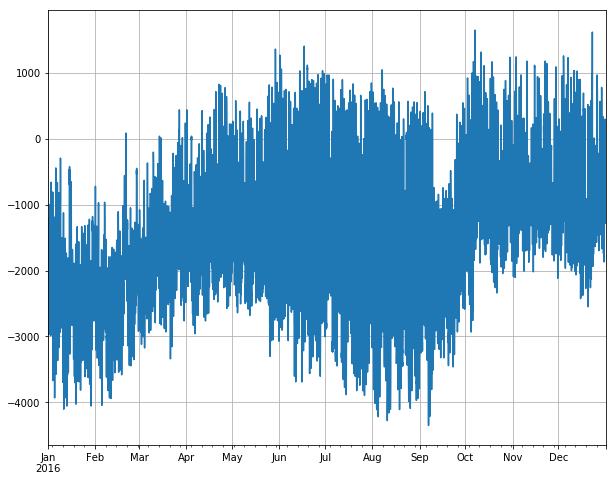

In [6]:
(eastern_demand_2016['MISO'] - miso_subarea_demand.sum(axis=1)).plot(figsize = (10,8),grid = True)

C:\Users\bxia\Anaconda\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


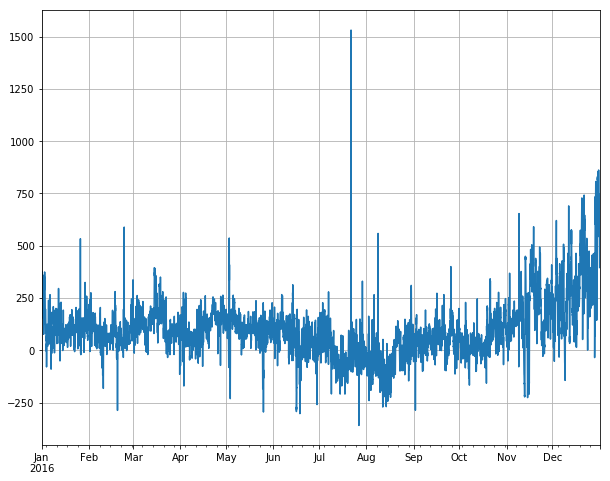

In [7]:
(eastern_demand_2016['SWPP'] - spp_subarea_demand.sum(axis=1)).plot(figsize = (10,8),grid = True)

Follow the profile shape of subarea profile and scale up to match the total absolute value from EIA for each hour.

In [8]:
frac_subarea_miso = miso_subarea_demand.copy()
for zone in miso_subarea_demand.columns:
    frac_subarea_miso[zone] = miso_subarea_demand[zone].divide(miso_subarea_demand.sum(axis=1)).multiply(eastern_demand_2016['MISO'])

In [9]:
frac_subarea_spp = spp_subarea_demand.copy()
for zone in spp_subarea_demand.columns:
    frac_subarea_spp[zone] = spp_subarea_demand[zone].divide(spp_subarea_demand.sum(axis=1)).multiply(eastern_demand_2016['SWPP'])

In [10]:
(eastern_demand_2016['SWPP'].sum() - spp_subarea_demand.sum().sum())/spp_subarea_demand.sum().sum()

0.0032739195084063545

In [11]:
(eastern_demand_2016['MISO'].sum() - miso_subarea_demand.sum().sum())/miso_subarea_demand.sum().sum()

-0.021408864093255642

C:\Users\bxia\Anaconda\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


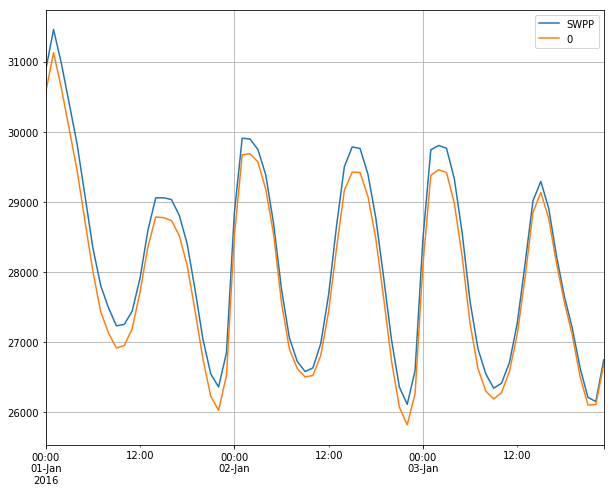

In [12]:
pd.concat([eastern_demand_2016['SWPP'].iloc[:72],spp_subarea_demand.sum(axis=1)[:72]],axis=1).plot(figsize = (10,8),grid = True)

C:\Users\bxia\Anaconda\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


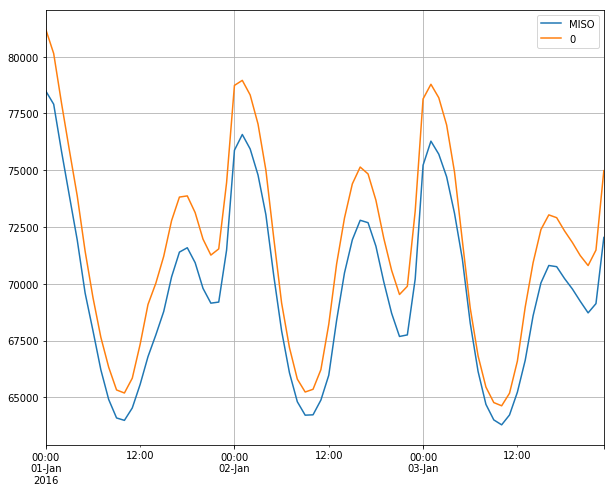

In [13]:
pd.concat([eastern_demand_2016['MISO'].iloc[:72],miso_subarea_demand.sum(axis=1)[:72]],axis=1).plot(figsize = (10,8),grid = True)

C:\Users\bxia\Anaconda\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


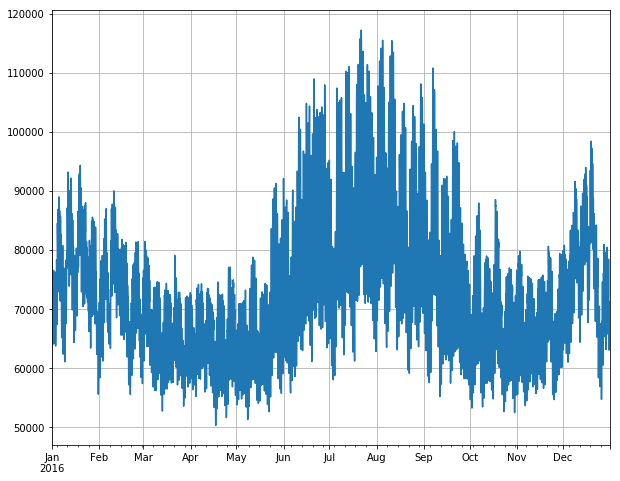

In [14]:
eastern_demand_2016['MISO'].plot(figsize = (10,8),grid = True)

C:\Users\bxia\Anaconda\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


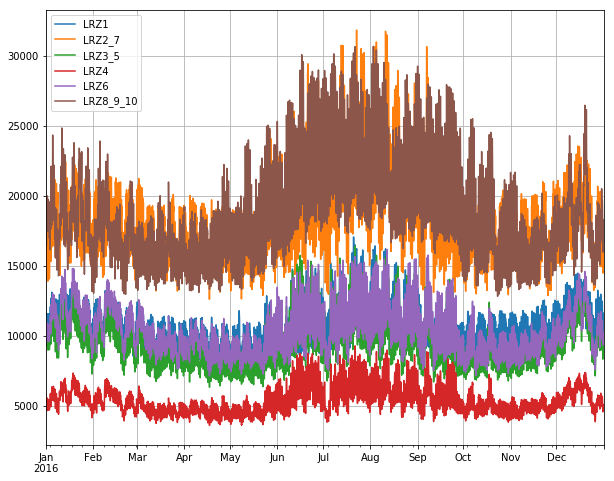

In [15]:
frac_subarea_miso.plot(figsize = (10,8),grid = True)

C:\Users\bxia\Anaconda\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


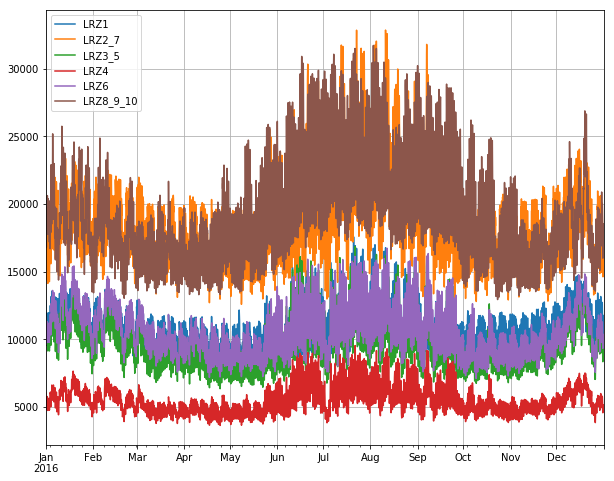

In [16]:
miso_subarea_demand.plot(figsize = (10,8),grid = True)

C:\Users\bxia\Anaconda\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


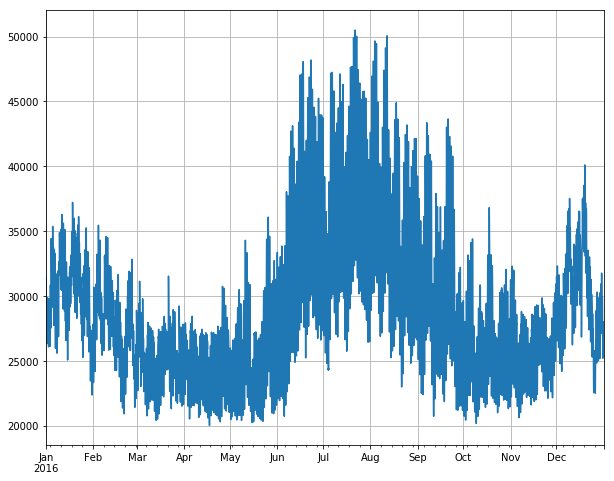

In [17]:
eastern_demand_2016['SWPP'].plot(figsize = (10,8),grid = True)

C:\Users\bxia\Anaconda\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


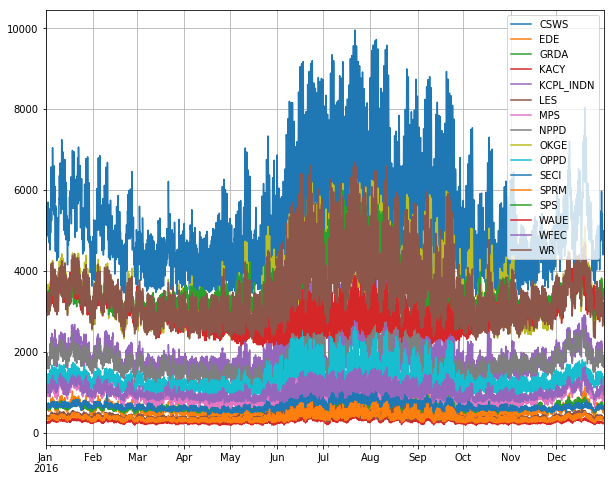

In [18]:
frac_subarea_spp.plot(figsize = (10,8),grid = True)

C:\Users\bxia\Anaconda\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


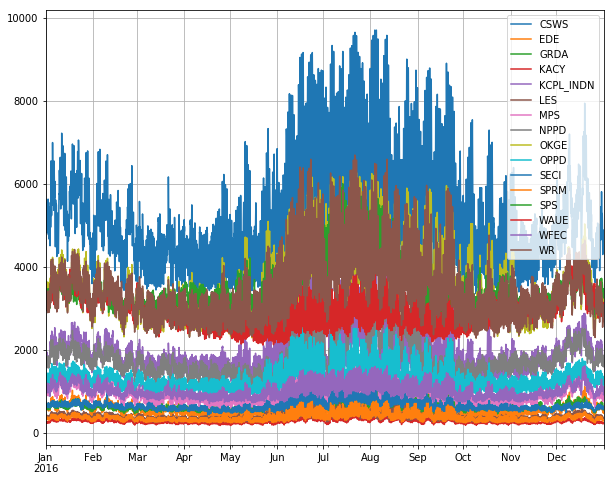

In [19]:
spp_subarea_demand.plot(figsize = (10,8),grid = True)

In [20]:
eastern_demand_2016 = pd.concat([eastern_demand_2016, frac_subarea_miso, frac_subarea_spp],axis=1)

Some BAs are very small. In these cases, BAs are agregated into BA areas as follows:

In [21]:
BA_area ={
        'ISNE':['ISNE'],
        'NYIS':['NYIS'],
        'PJM':['PJM','OVEC'],
        'AEC':['AEC'],
        'SOCO':['SOCO'],
        'TVA_LGEE':['TVA','LGEE'],
        'Florida':['TAL','JEA','GVL','SEC','FPC','NSB','FMPP','TEC','FPL','HST'],
    
        'AECI':['AECI'],

        #'MISO':['MISO','AECI'],
    
        'LRZ1': ['LRZ1'],
        'LRZ2_7': ['LRZ2_7'],
        'LRZ3_5': ['LRZ3_5'],
        'LRZ4': ['LRZ4'],
        'LRZ6': ['LRZ6'],
        'LRZ8_9_10': ['LRZ8_9_10'],
    
        #'SWPP':['SWPP','SPA'],
        'CSWS': ['CSWS','SPA'],
        'EDE': ['EDE'],
        'GRDA': ['GRDA'],
        'KACY': ['KACY'],
        'KCPL_INDN': ['KCPL_INDN'],
        'LES': ['LES'],
        'MPS': ['MPS'],
        'NPPD': ['NPPD'],
        'OKGE': ['OKGE'],
        'OPPD': ['OPPD'],
        'SECI': ['SECI'],
        'SPRM': ['SPRM'],
        'SPS': ['SPS'],
        'WAUE': ['WAUE'],
        'WFEC': ['WFEC'],
        'WR': ['WR'],

        'Carolina':['CPLW','DUK','SCEG','SC','CPLE']
        }


Use adjacent demand data to fill missing values using a series of rules:
1. Monday: look forward one day
2. Tues - Thurs: average of look forward one day and look back one day
3. Fri: look back one day
4. Sat: look forward one day
5. Sun: look back one day

If data is still missing after applying the above rules, week ahead and week behind data is used
1. Monday: look forward two days 
2. Tues: look forward two days
3. Wed: average of look forward two days and look back two days
4. Thurs: look back two days
5. Fri: look back two days
6. Sat - Sun: average of look back one week and look forward one week

If data is still missing after applying the above rules, week ahead and week behind data is used:
1. Mon - Sun: average of look back one week and look forward one week

In [22]:
eastern_agg_demand = transform_demand_to_region.transform_ba_to_region(eastern_demand_2016, BA_area)
eastern_agg_demand

ISNE regional demand was summed from ['ISNE']
NYIS regional demand was summed from ['NYIS']
PJM regional demand was summed from ['PJM', 'OVEC']
AEC regional demand was summed from ['AEC']
SOCO regional demand was summed from ['SOCO']
TVA_LGEE regional demand was summed from ['TVA', 'LGEE']
Florida regional demand was summed from ['TAL', 'JEA', 'GVL', 'SEC', 'FPC', 'NSB', 'FMPP', 'TEC', 'FPL', 'HST']
AECI regional demand was summed from ['AECI']
LRZ1 regional demand was summed from ['LRZ1']
LRZ2_7 regional demand was summed from ['LRZ2_7']
LRZ3_5 regional demand was summed from ['LRZ3_5']
LRZ4 regional demand was summed from ['LRZ4']
LRZ6 regional demand was summed from ['LRZ6']
LRZ8_9_10 regional demand was summed from ['LRZ8_9_10']
CSWS regional demand was summed from ['CSWS', 'SPA']
EDE regional demand was summed from ['EDE']
GRDA regional demand was summed from ['GRDA']
KACY regional demand was summed from ['KACY']
KCPL_INDN regional demand was summed from ['KCPL_INDN']
LES regional

,ISNE,NYIS,PJM,AEC,SOCO,TVA_LGEE,Florida,AECI,LRZ1,LRZ2_7,...,NPPD,OKGE,OPPD,SECI,SPRM,SPS,WAUE,WFEC,WR,Carolina
2016-01-01 00:00:00+00:00,16063.0,19726.0,95072.0,492.0,23927.0,23022.0,33518.0,2917.0,12433.625635,18935.912114,...,1935.360424,3680.231068,1531.332910,748.622744,402.975659,3587.312171,3619.588079,1115.993263,3570.464646,22878.0
2016-01-01 01:00:00+00:00,15273.0,19008.0,92298.0,488.0,24347.0,22800.0,31645.0,2946.0,12292.755041,18580.001578,...,1981.483410,3734.738487,1549.895292,764.789182,402.078672,3696.936352,3643.513352,1142.849782,3658.209541,22097.0
2016-01-01 02:00:00+00:00,14568.0,18340.0,89416.0,465.0,23574.0,22258.0,22897.0,2910.0,11892.432899,17939.883463,...,1940.735382,3703.713583,1513.463335,750.701658,390.615840,3674.371288,3582.780463,1148.714183,3582.793021,21357.0
2016-01-01 03:00:00+00:00,13850.0,17557.0,86496.0,444.0,22762.0,21679.0,26967.0,2878.0,11554.337721,17359.510187,...,1898.155404,3648.618172,1474.868777,736.069726,379.830057,3626.131980,3525.447208,1143.648011,3506.871042,20466.0
2016-01-01 04:00:00+00:00,13108.0,16772.0,83405.0,429.0,21857.0,21099.0,25011.0,2829.0,11222.455123,16785.186093,...,1859.707744,3586.621688,1428.755692,722.883309,369.539204,3578.911415,3469.432510,1137.463356,3438.861340,19469.0
2016-01-01 05:00:00+00:00,12737.0,16055.0,80685.0,410.0,20974.0,20400.0,23146.0,2779.0,10817.628840,16111.608142,...,1809.892131,3491.832328,1368.179801,705.398191,356.677810,3523.683650,3402.717199,1130.234515,3343.000907,18412.0
2016-01-01 06:00:00+00:00,12503.0,15250.0,78741.0,394.0,20711.0,19948.0,22040.0,2707.0,10681.587499,15491.636223,...,1764.015262,3406.550009,1309.285161,678.315792,343.239392,3447.980449,3330.079695,1116.782145,3240.796714,17505.0
2016-01-01 07:00:00+00:00,12241.0,14583.0,77897.0,366.0,20505.0,19541.0,20847.0,2681.0,10337.147071,14947.946506,...,1739.188289,3347.755063,1272.494499,663.667004,336.179714,3386.326682,3291.308024,1104.500425,3160.871994,16968.0
2016-01-01 08:00:00+00:00,11824.0,14013.0,76367.0,348.0,20051.0,19144.0,19535.0,2643.0,9992.803245,14475.290055,...,1724.721334,3300.255530,1249.244958,652.780105,330.238732,3346.849027,3247.144049,1101.908955,3101.712883,16444.0
2016-01-01 09:00:00+00:00,11616.0,13632.0,75626.0,341.0,19761.0,19017.0,18638.0,2653.0,9788.870555,14189.303948,...,1710.293029,3264.010306,1227.617961,646.963657,325.621754,3328.681579,3211.456170,1085.603819,3060.249961,16108.0


In [23]:
eastern_agg_demand.to_pickle("./eastern_agg_demand.pkl")

Indentify and fix outliers. Outliers defined as demand hours for which the ramp rate (difference between two hours) is greater than 3 standard deviations of the ramp rates for the BA across all hours in the year. 
Demand data for hours identified as outliers are replaced with the average of the neighboring non-outlier hour's demand.
Stretches of >5 consecutive outlier hours are flagged.

In [24]:
eastern_fix_outliers = find_fix_outliers.fix_dataframe_outliers(eastern_agg_demand)


ISNE

NYIS

PJM
1357 104873.0 104873.0
1358 137033.0 104409.0
1359 103945.0 103945.0

AEC

SOCO
2410 19206.0 19206.0
2411 26343.0 19742.0
2412 20278.0 20278.0

TVA_LGEE
701 23378.0 23378.0
702 4517.0 22913.0
703 22448.0 22448.0
7469 16362.0 16362.0
7470 4106.0 15976.0
7471 15590.0 15590.0
8237 25897.0 25897.0
8238 5649.0 25647.5
8239 25398.0 25398.0
8477 28120.0 28120.0
8478 7081.0 27567.5
8479 27015.0 27015.0

Florida
1 31645.0 31645.0
2 22897.0 22897.0
1564 18918.0 18918.0
1565 28308.0 18278.0
1566 17638.0 17638.0
1876 31575.0 31575.0
1877 21080.0 21080.0
3412 33165.0 33165.0
3413 23562.0 23562.0
4850 38735.0 38735.0
4851 27638.0 27638.0
6094 42074.0 42074.0
6095 30860.0 30860.0
6171 30200.0 30200.0
6172 21228.0 21228.0
6266 34131.0 34131.0
6267 24657.0 24657.0
6746 26350.0 26350.0
6747 15276.0 15276.0
7195 30944.0 30944.0
7196 41548.0 31338.5
7197 31733.0 31733.0
7633 27013.0 27013.0
7634 15766.0 15766.0

AECI

LRZ1

LRZ2_7

LRZ3_5

LRZ4

LRZ6

LRZ8_9_10

CSWS

EDE

GRDA
2746 629.6

## Get bus to BA area mapping via county
Author: Bainan  
Last updated: 11/14/19

First, get Eastern grid. 

In [25]:
eastern = Grid(['Eastern'])

--> Loading Eastern interconnect
Loading zone
Loading sub
Loading bus2sub
Loading bus
Loading plant
Loading plant cost
Loading branch
Loading DC line


Warning: the following step takes around 3 hours to finish. The results are stored in bus_ba_map.csv for future use, as implemented below:

In [15]:
#bus_ba_map, bus_no_BA_match = map_grid_buses_to_county(eastern)*

#bus_ba_map.to_csv('bus_ba_map.csv')*

The csv file is created at this stage to aviod time-intensive reruns.

In [20]:
bus_ba_map = pd.read_csv('bus_ba_map.csv',index_col=0)

The following step loads a file that stores list of counties in each BA area territory. The file is created mannually based on external references.

In [22]:
data = json.load(open('EasternBAtoCountyDraft6.txt'))
ba_county_list = {}
for val in data['groups'].values():
    ba_county_list[val['label']] = set(val['paths'])

In [ ]:
for index,row in bus_ba_map.iterrows():
    for BA,clist in ba_county_list.items():
        try:
            county = row['County'].replace(' ','_')
            county = county.replace('.','')
            county = county.replace('-','')
            county = county.replace('\'','_')
            if row['County'] == 'LaSalle__IL':
                county = 'La_Salle__IL'
            if row['County'] == 'Lac Qui Parle__MN':
                county = 'Lac_qui_Parle__MN'
            if row['County'] == 'Baltimore__MD':
                county = 'Baltimore_County__MD'
            if row['County'] == 'District of Columbia__DC':
                county = 'Washington__DC'
            if row['County'] == 'St. Louis City__MO':
                county = 'St_Louis_Co__MO'
            if county in clist:
                bus_ba_map.loc[index,'BA'] = BA
                break
        except:
            continue

In [ ]:
bus_ba_map

Check if there are buses where BA is empty/not found, which is due to bus being outside of United States. These were fixed manually by assigning to the nearest county. This procedure is commented out as it was used just one time. 

Check if there are any buses where BA is null, which is due to a name mis-match.

Then check if there are buses where county is null. 

In [23]:
#bus_no_BA_match = list(bus_ba_map[~bus_ba_map['BA'].astype(bool)].index)

bus_no_BA_match = list(bus_ba_map[bus_ba_map['BA'].isna()].index)
bus_no_BA_match

[]

In [ ]:
bus_no_county_match = list(bus_ba_map[bus_ba_map['County'].isna()].index)
bus_no_county_match

Add zone name into the data frame for reference.

In [24]:
bus_ba_map.loc[:,'zone_name'] = eastern.bus[eastern.bus['Pd']>0]['zone_id'].apply(lambda x: eastern.id2zone[x])

Fix mismatch county names in Virginia and Maryland

In [25]:
for ind in bus_no_BA_match:
    if bus_ba_map.loc[ind,'zone_name'] in {'Virginia Mountains','West Virginia','Virginia Tidewater','Maryland'}:
        bus_ba_map.loc[ind,'BA'] = 'PJM'

## Manually assign outliers (outside US territory) to the nearest BA
Bus no county match: [91: ISNE, 7991: NYIS, 7992: NYIS, 8707: NYIS, 8708: NYIS, 40644: MISO]  
Assign the rest no-ba-match buses to SWPP.  
Assign buses in ERCOT Texas to SWPP or MISO based on the location by observation.  
Make BA code cosnistent with EIA data source.  
Overwrite the final results with two new columns for each row (bus): BA and zone_name. 

In [26]:
# Manually assign outliers (outside US territory) to the nearest BA
# bus no county match: [91: ISNE, 7991: NYIS, 7992: NYIS, 8707: NYIS, 8708: NYIS, 40644: MISO]
bus_ba_map.loc[91,'BA'] = 'ISNE'
bus_ba_map.loc[7991,'BA'] = 'NYIS'
bus_ba_map.loc[7992,'BA'] = 'NYIS'
bus_ba_map.loc[8707,'BA'] = 'NYIS'
bus_ba_map.loc[8708,'BA'] = 'NYIS'
bus_ba_map.loc[40644,'BA'] = 'MISO'

# Assign the rest no-ba-match buses to SWPP
for ind in bus_no_BA_match:
    bus_ba_map.loc[ind,'BA'] = 'SWPP'

# Assign buses in ERCOT Texas to SWPP or MISO based on the location by observation
miso_tx_ind = bus_ba_map[(bus_ba_map['BA']=='ERCOT Texas') & (bus_ba_map['zone_name']=='East Texas') & ((bus_ba_map['County']=='Montgomery__TX') | (bus_ba_map['County']=='Walker__TX'))].index
for ind in bus_ba_map[bus_ba_map['BA']=='ERCOT Texas'].index:
    if ind in miso_tx_ind:
        bus_ba_map.loc[ind,'BA']='MISO'
    else:
        bus_ba_map.loc[ind,'BA']='SWPP'

# Make BA Code consistent with EIA data source
ba_code_fix = {'ISONE':'ISNE','NYISO':'NYIS'}
bus_ba_map.replace(ba_code_fix,inplace=True)

# The csv file is overwritten by the final results with two new columns for each row (bus): BA and zone_name.
bus_ba_map.to_csv('bus_ba_map.csv')

### Generate final demand profile

In [26]:
bus_map = pd.read_csv('bus_ba_map.csv',index_col=0)
bus_map_spp = pd.read_csv('bus_ba_map_spp.csv',index_col=0)
bus_map_miso = pd.read_csv('MISO_mapping.csv',index_col=0)
# bus_map.set_index('bus_id')

In [27]:
bus_map_miso['BA'] = bus_map_miso['miso_zone']
bus_map_miso.drop(columns=['miso_zone','state'],inplace=True)

In [28]:
no_miso_spp_bus_map = bus_map[~((bus_map['BA']=='MISO')|(bus_map['BA']=='SWPP'))]

In [29]:
bus_map_new = pd.concat([no_miso_spp_bus_map,bus_map_miso,bus_map_spp]).sort_index()

Transform to load zone using the demand that has missing data filled and outliers fixed, prepared from the first steps in the demo notebook.

In [30]:
final_eastern_demand =  transform_ba_to_loadzone.map_to_loadzone(eastern_fix_outliers, bus_map_new)
final_eastern_demand

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,Alabama,Florida Panhandle,Arkansas,Illinois Downstate,Missouri East,East Texas,Kansas,Louisiana,Missouri West,Oklahoma,...,Mississippi,New Jersey,Pennsylvania Eastern,Pennsylvania Western,Delaware,Maryland,Virginia Tidewater,West Virginia,New Mexico Eastern,Texas Panhandle
2016-01-01 00:00:00+00:00,8786.369603,2197.372586,5644.746112,5228.379425,8291.504918,2106.919642,5866.790904,10101.550890,3165.081880,8062.935551,...,6371.275950,11711.598199,11124.355240,5559.094083,1457.475255,9771.440984,9705.345710,3013.381864,732.581161,2707.404584
2016-01-01 01:00:00+00:00,8858.210591,2178.567542,5732.560622,5115.326989,8329.564821,2143.316968,5997.488044,10233.696779,3198.587020,8216.716461,...,6401.191837,11365.838316,10799.704824,5396.817214,1414.949208,9486.330991,9422.164237,2925.457751,754.968009,2790.139790
2016-01-01 02:00:00+00:00,8589.958870,1929.228439,5634.815025,4991.177947,8153.308185,2106.183772,5862.632717,10064.351684,3123.339017,8138.584462,...,6275.837637,11008.828130,10462.450517,5228.263066,1370.767497,9190.120825,9127.957674,2834.110493,750.359896,2773.109558
2016-01-01 03:00:00+00:00,8310.201108,1975.728787,5528.395836,4848.896786,8000.256007,2067.820159,5729.416035,9863.334033,3053.418440,8032.401664,...,6132.717468,10644.098537,10120.700774,5057.431124,1326.003236,8890.005042,8829.871913,2741.558794,740.508729,2736.702544
2016-01-01 04:00:00+00:00,8014.008672,1876.646868,5401.843789,4711.839312,7845.598872,2020.270422,5606.574756,9638.568414,2987.138260,7899.017874,...,5980.800019,10259.253684,9758.957691,4876.617844,1278.617508,8572.313986,8514.329760,2643.587117,730.865605,2701.064393
2016-01-01 05:00:00+00:00,7705.809296,1780.939214,5251.340199,4685.917977,7585.236997,1963.896441,5453.049793,9370.452636,2901.610771,7720.120362,...,5800.694553,9919.856439,9440.621130,4717.493169,1236.919293,8292.754079,8236.660832,2557.374576,719.587295,2659.383074
2016-01-01 06:00:00+00:00,7576.493824,1739.522536,5135.759453,4549.782252,7406.064592,1918.722365,5301.102318,9179.590508,2832.622199,7544.533954,...,5682.101957,9668.988931,9212.970110,4603.613314,1207.117333,8092.950969,8038.209215,2495.757966,704.127603,2602.248600
2016-01-01 07:00:00+00:00,7453.951281,1699.324364,5033.771683,4357.737854,7311.075342,1881.321136,5159.488877,8990.164556,2778.395567,7424.334936,...,5566.811331,9551.067249,9113.988533,4554.006129,1194.178622,8006.205174,7952.050180,2469.006722,691.537010,2555.717469
2016-01-01 08:00:00+00:00,7283.194001,1641.818548,4987.610949,4261.807091,7211.663429,1864.172531,5086.433685,8907.867527,2755.248368,7349.874276,...,5491.624650,9355.428235,8934.847865,4464.411603,1170.723376,7848.952727,7795.861408,2420.512168,683.475101,2525.923022
2016-01-01 09:00:00+00:00,7192.689906,1603.761276,4950.856720,4247.200278,7166.266201,1849.276948,5041.938303,8850.513559,2740.514832,7269.845735,...,5455.196391,9257.700936,8848.039512,4420.965037,1159.363679,7772.793208,7720.217042,2397.025589,679.765045,2512.211745


In [31]:
index_reference = pd.read_csv('spp_subarea_demand_profile_2016.csv',index_col=0)
final_eastern_demand.index = index_reference.index

In [32]:
final_eastern_demand.columns = [eastern.zone2id[col] for col in final_eastern_demand.columns]
final_eastern_demand = final_eastern_demand.sort_index(axis = 1)

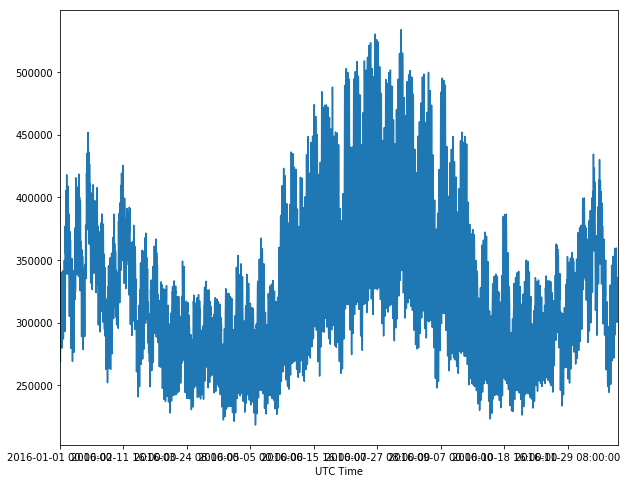

In [33]:
final_eastern_demand.sum(axis=1).plot(figsize=(10,8))

In [34]:
final_eastern_demand.to_csv('eastern_demand_v6.csv')